<a href="https://colab.research.google.com/github/Cezarrr9/Digit-Recognizer/blob/main/mnist_tutorial_using_fastai_and_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This version of code is meant to be run outside of kaggle. However, you can find the Kaggle version of the code here: https://www.kaggle.com/code/cezarr/mnist-tutorial-using-fastai-and-pytorch

# Get the data

The simplest way to access Kaggle datasets is through the Kaggle API. This can be installed using pip by running the following cell:

In [ ]:
!pip install kaggle

Then, in order to use Kaggle API, we need an API key. You can find this by clicking on your profile picture on Kaggle → Account → Create New Token. A json file will be saved in your PC. You need to access it, copy its contents and then paste them in the following cell (between the quotes):

In [19]:
# this needs to be run just once
creds = 'insert_here'

You can run the following cells that will download the datasets to the specified path and then extract them:

In [20]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [21]:
path = Path('digit-recognizer')

In [22]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 15.3M/15.3M [00:00<00:00, 22.6MB/s]


We import some libraries:

In [23]:
import fastai
from fastai.vision.all import *
import torch
import pandas as pd
import numpy as np

In [25]:
# Get the training data
train_data = pd.read_csv(path/'train.csv')

# Get the test data
test_data = pd.read_csv(path/'test.csv')

# Data Processing

Create two paths for accessing the training and test data:

In [26]:
TRAIN = Path("../train")
TEST = Path("../test")

We create 10 directories that represent every class that an image can be assigned to (the digits from 0 to 9):

In [27]:
# 'makedirs' creates a directory recursively
for digit in range(10):
    os.makedirs(TRAIN/str(digit))

In [28]:
# Here we can see the name of each director
sorted(os.listdir(TRAIN))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [29]:
# 'makedirs' also creates all intermediate-level directories needed to contain the leaf directory
os.makedirs(TEST)

Here we create a function that helps us save digits as images not just as arrays:

In [30]:
# PIL = Python Imaging Library
from PIL import Image

def save_digit(path, digit):
    digit = digit.reshape(28, 28) # 'reshape' changes the shape of an array
    digit = digit.astype(np.uint8) # 'astype' changes the data type of the numbers inside an array
    img = Image.fromarray(digit) # 'fromarray' creates an image object from a given array
    img.save(path) # save the image into the specified directory

Now we want to put the training images (in jpg format) in the director named after their label:

In [31]:
for index, row in train_data.iterrows():
    label, digit = row[0], row[1:]

    director = TRAIN / str(label)
    fname = f"{index}.jpg"
    path = director / fname

    digit = digit.values

    save_digit(path, digit)

The test images are put in the TEST directory in jpg format:

In [32]:
for index, digit in test_data.iterrows():
    director = TEST
    fname = f"{index}.jpg"
    path = director / fname

    digit = digit.values

    save_digit(path, digit)

Now, we want to construct a DataBlock. In order to train a neural network in FastAI, the data needs to be stored in DataBlock. We use just a few parameters for building ours. If you want to explore all the capabilities of a DataBlock please check out the official documentation.

The 'blocks' parameter asks for one or more types of blocks in order to know how to organize the data. I used ImageBlock for the pictures and CategoryBlock for their labels. 'get_items' represents the function used to get the items into the image block. 'splitter' is used to split the data into training and validation data; if you use a seed the random split will be the same all the time you'll run the cell. 'get_y' refers to a function used to get the labels for each picture (category block). We defined the 'get_label' function to do this exact thing for us.

In [33]:
def get_label(fname):
    return fname.parent.name

In [34]:
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed = 42),
                  get_y = get_label)

# We use dataloaders function to load the training data
dls = digits.dataloaders(TRAIN)

# Model Training

Here we create our vision learner.
FastAI includes some pretrained models for computer vision such as resnet34, densenet169, vgg16_bn, etc. Our first try is to fine tune one of these models on our training data.

In [35]:
# The vision learner takes as parameters a dataloader, a model and a metric in order to measure the performance of the model.
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2) # Here we specify the number of epochs for which we do the fine-tuning

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 246MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.847442,0.607547,0.193095,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.144850,0.090916,0.029524,01:01
1,0.067161,0.055511,0.016190,00:55


In [36]:
# We can use 'one_batch' method to see the images from a batch and their labels
x, y = dls.one_batch()

Here are the labels:

In [37]:
y

TensorCategory([9, 8, 7, 6, 2, 9, 6, 6, 6, 4, 6, 9, 7, 1, 7, 3, 0, 1, 5, 1, 1,
                7, 8, 7, 7, 5, 9, 4, 2, 3, 9, 6, 1, 9, 0, 8, 4, 4, 9, 7, 9, 7,
                4, 3, 5, 5, 6, 9, 9, 1, 5, 5, 3, 6, 0, 7, 8, 0, 8, 9, 9, 3, 0,
                6], device='cuda:0')

We use 'get_preds' to get predictions regarding the label of every picture. The method returns a list of probabilities for each one of them. These probabilities represent how sure the model is about what digit is in the image.

In [38]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([3.8857e-05, 9.8225e-06, 1.7927e-05, 3.9876e-04, 5.9594e-04, 8.2671e-05,
        2.2666e-06, 1.4376e-04, 2.4770e-04, 9.9846e-01])

In our case, we get 10 probabilities, because there are 10 classes (an image can represent a digit from 0 to 9). All those probabilities sum up to 1.

In [39]:
len(preds[0]), preds[0].sum()

(10, tensor(1.0000))

We can plot a confusion matrix by using ClassificationInterpretation class provided by FastAI:

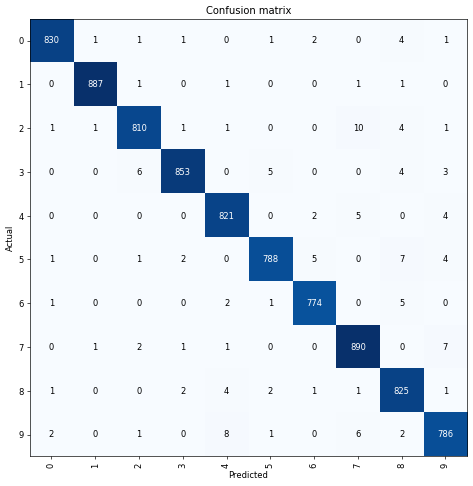

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (8, 8), dpi = 60)

We can observe how many images were classified correctly by our model on the main diagonal of the matrix and how many were misclassified anywhere else.

In [41]:
# We can also see what digits were the most confused
interp.most_confused(min_val = 5)

[('2', '7', 10),
 ('9', '4', 8),
 ('5', '8', 7),
 ('7', '9', 7),
 ('3', '2', 6),
 ('9', '7', 6),
 ('3', '5', 5),
 ('4', '7', 5),
 ('5', '6', 5),
 ('6', '8', 5)]

Now, we would want to improve our model by selecting a different learning rate. FastAI offers us a tool to do just that: the learning rate finder. For more information about how this works check out the official documentation.

You can find the research that inspired the creation of this method here: https://arxiv.org/pdf/1506.01186.pdf.

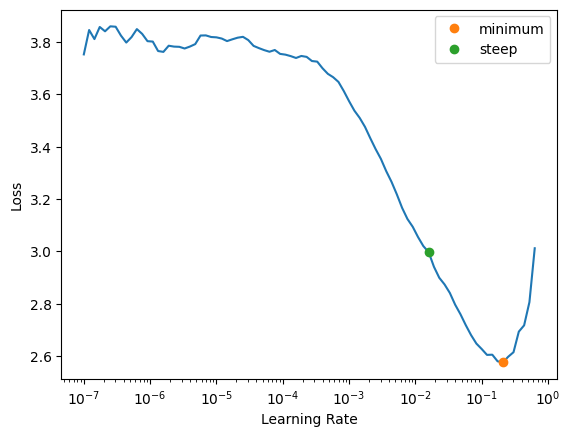

In [42]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs = (minimum, steep))

In [43]:
lr_min, lr_steep

(0.02089296132326126, 0.015848932787775993)

We want to respect one of the following criteria when we choose a learning rate:
* to be one order of magnitude smaller than the value where the minimum value of the loss was achieved (this means 10 times smaller than the value where we found the minimum)
* to be the last point where the loss was clearly decreasing

In [44]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2, base_lr = 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.352900,0.158470,0.043810,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.132685,0.094719,0.026548,00:55
1,0.049719,0.027368,0.009286,00:55


# Making Predictions

Now we want to make predictions on our test data. The 'glob' function is used to match all the paths that contain files that end in '.jpg'; it returns an object generator, so in order to work with the paths we created a list.

In order to make predictions on new data we have to create the test dataloader. That's what the second line of code does. In order to make the predictions on this test dataloader we have to specify it when we call 'get_preds' (we did this by writing "dl = test_dl"). As we explained before, 'get_preds' returns a list of probabilities for each image. That's why we use 'argmax' to get the index where the biggest probability can be found. The indexes range from 0 to 9 and match the names of our classes perfectly.

In [45]:
test_images = list(TEST.glob("*.jpg"))
test_dl = learn.dls.test_dl(test_images)

predictions, _ = learn.get_preds(dl = test_dl)
predictions = np.argmax(predictions, axis = 1)

The 'stem' method extracts the name of a file without its extension. We used it to get the ids of all the images and then match them with the labels computed by the model.

In [46]:
ids = [int(path.stem) + 1 for path in test_images]
submission_data = pd.DataFrame({"ImageId": ids, "Label": predictions})

Finally, we create a csv file with our predictions using 'to_csv' method:

In [47]:
submission_data.to_csv('submission.csv', index = False)